## Unsupervised Learning Group Activity - Week 9

###### Images will only load if you are connected to the internet.


A cool application of unsupervised learning that is highly relevant at RV is to analyze a corpus of text to identify clusters or topics present in the corpus.

RV produces ~130k pieces of content a year (as of 2022), and spends approx. \\$70MM on content production, and our content heavy businesses generate on the order of \\$1BB in revenue.

For those reasons - it seems like a good idea to be able to analyze and categorize our content to form groups - to then join to performance data/seo data to understand what works well, what works poorly, which types of content should we invest in more etc. This is something we have done in the past with manual editor tags or site folders, but that can often be inconsistent and subject to human error that makes proper analysis and grouping basically impossible - especially on larger sites or when taking an RV portfolio viewpoint.

We actually have a product at Red Ventures that serves this use case called the Content Platform - this tool powers a variety of capabilities around content analysis, website personalizatoin and contextual ad targeting. You can read more about that technology here - it was unsupervised learning to "discover" the global RV tag taxonomy from data, and then a supervised learning task to classify new articles - https://redventures.atlassian.net/wiki/spaces/CP/pages/19585532184/Global+Tagging+Model


In this activity we will take a sample of ~10k articles from the M&C vertical, turn the unstructured text into numeric data to feed to a model, and apply an unsupervised technique called "topic modelling" to the dataset.
Topic modelling is very similar to clustering - one of the most common and powerful tools for topic modelling is called "Latent Dirichlet Allocation" (LDA) - https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf

<img src="https://www.researchgate.net/profile/Amir-Karami/publication/325976766/figure/fig1/AS:641555870253057@1529970247271/Intuition-Behind-LDA-2.png">

### LDA Intuition

At a high level the LDA model attempts to model two probability distributions given data that is "words present in documents".

1. The probability of a topic over words - $p(word|topic)$ - Each "Topic" is a probability distribution over the words in that topic - for example a topic about sports might have high likelihood words such as "basketball, referree, football".

2. The probability of a document over topics $p(topics|document)$ - Each document can be represented as a probability distribution over "topics" by using the words in the document and the distribution above - for example an article about Davidson beating Duke at basketball might have high likelihood over topics for sports and college.


The approach above makes this model very cool and flexible - providing "soft"/probabalistic membership of documents into many topics - and the choice of the Dirichlet distribution helps to make topics distinct from one another.
Additionally while it is "famous" for working on text - LDA is just an unsupervised learning algorithm that can be used for several downstream algorithms similar to most clustering or matrix factorization algorithms.
If you really want to go deep on the math we've linked the original paper by David Blei and team above.

<img src = "https://www.researchgate.net/publication/346801402/figure/fig1/AS:986776055345152@1612277153515/LDA-underlying-intuition-Generation-of-documents-through-topics-following-the-Dirichlet.png">



### Load dependencies and helper functions

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(len(model.components_)/5), 5, figsize=(20, 6*math.ceil(len(model.components_)/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [str(topic_idx+1)]+top_features
        topic_names.append("_".join(top_features))
        
        
    return topic_names

    

### We created a clean data set of articles, titles and most recent publish dates for this exercise - you can find the dataset here - 

In [2]:
data = pd.read_csv("week9_activity_cmg_articles_clean.csv")

In [3]:
data.head()

,Unnamed: 0,date,msg_title,cleaned_text
0,0,2022-04-23,Elden Ring Is Being Demade For An Actual Game Boy,"Arise ye Tarnished, someone is making a Game B..."
1,1,2022-04-23,"In Dune: Spice Wars, The Planet Arrakis Is As ...","Dune, Frank Herbert's seminal 1965 sci-fi nove..."
2,2,2022-04-23,Sea Of Thieves The Shrouded Deep Guide,Sea of Thieves Adventure 3 has arrived. In The...
3,3,2022-04-23,PAX East 2022: Lucid Crosses Celeste With Metr...,Apogee's rebranding has been a kind of return ...
4,4,2022-06-25,Movies Like 'Blade Runner' to Watch Next,Based on Philip K. Dick 's novel Do Androids D...


In [4]:
data.shape

(10000, 4)

In [5]:
texts = data.cleaned_text

### Vectorizing Text

First, we're going to turn our original unstructured data (raw text) into a form usable by ML models.

The technique we are going to use to turn our text data into a numeric matrix is called "bag of words" - 
- 1 document = 1 row
- 1 word in our vocabulary = 1 column
- each entry = count of occurences of that word (column) in that document (row)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [7]:
#define our vectorizer class
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words="english", ngram_range=(1, 2))


In [10]:
#fit the vectorizer to our text data and apply the transformation
tf = tf_vectorizer.fit_transform(texts)

In [16]:
# Each document is now a 1x10000 matrix as described above, and we have 10000 documents
print("Shape =",tf.shape)
tf[0]

Shape = (10000, 10000)


<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 115 stored elements in Compressed Sparse Row format>

In [38]:
#'tf_vectorizer.vocabulary_' this is our "vocabulary" that we inferred from the text 
#each word token we extracted and the count of that word token across the corpus
pd.DataFrame.from_dict(tf_vectorizer.vocabulary_,orient = "index").head(30)

,0
arise,860
tarnished,8852
making,5482
game,3848
boy,1382
favorite,3485
elden,3061
ring,7605
development,2677
process,6916


### Set up the LDA Model

Similar to many clustering techniques, one of the main inputs to LDA is the number of topics - `n_components`.

There are other related techniques that try to infer the number of topics from the data itself such as hierarchical LDA - but the "base" model requires that input.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [42]:
n_components = 40
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    random_state=0,
    verbose = 2 # this could take a little bit, so we specify higher verbosity for some logs
)

##### Fit our LDA model and store the topic distributions for each document in `clusters`

In [43]:
clusters = lda.fit_transform(tf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 3 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 4 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s finished


### Now, we can visualize our topics

You can try playing around with different params and see what results you get.

The main things to tune are:
1. The number of topics - `n_components`
2. The parameters of the CountVectorizer - which basically play with how many words you would extract from the text and some logic on top of that, and therefore how many/what type of columns you have in your vectorized matrix.

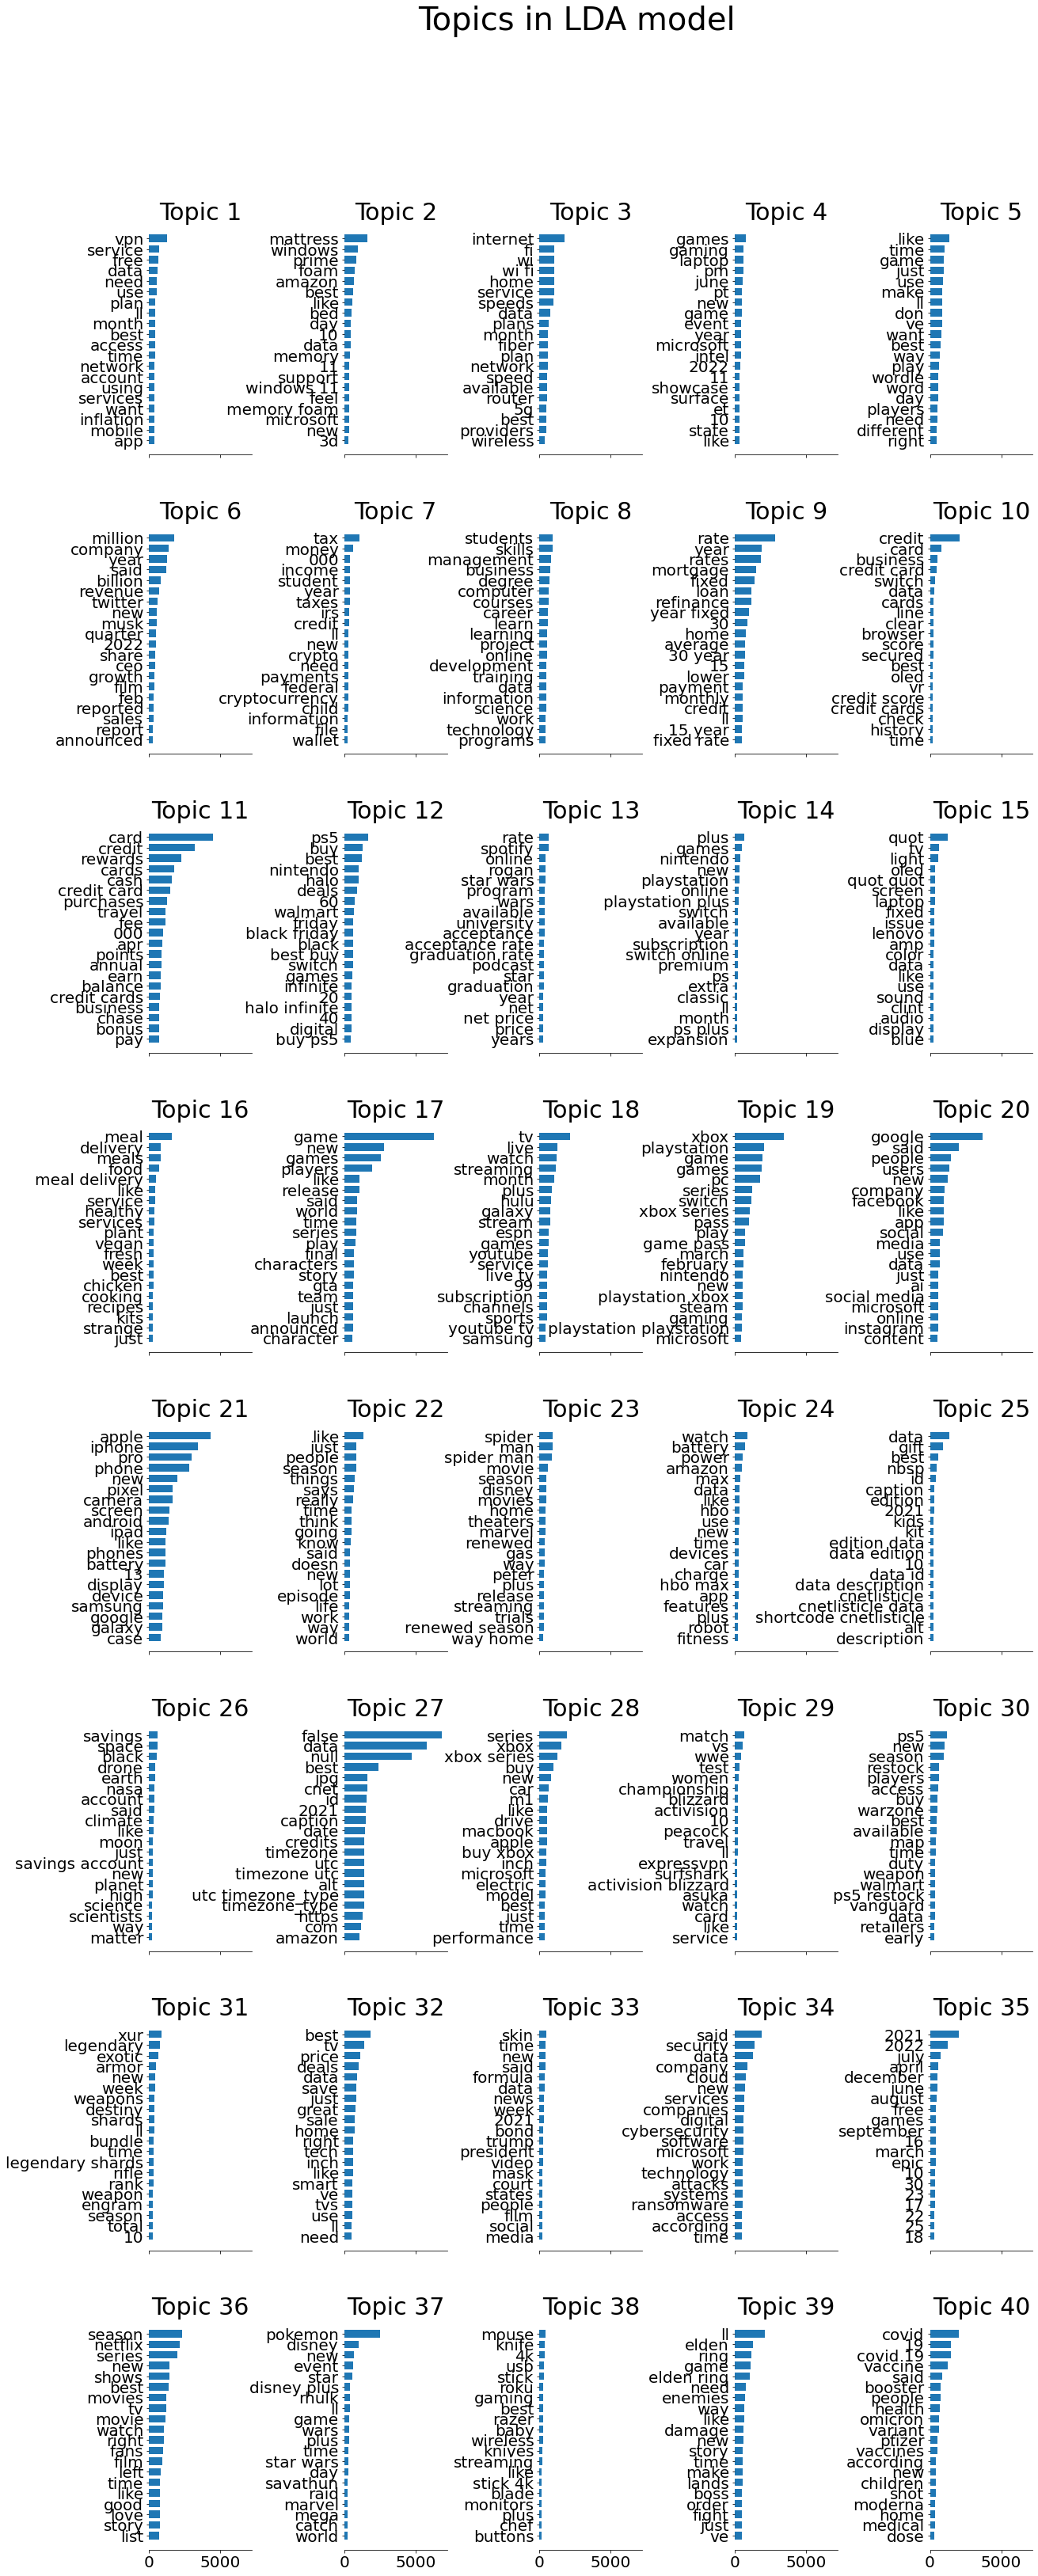

In [44]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### We can also visualize the topic distribution of a particular article - because of how the LDA model works

The code below will take a random sample article and visualize the topic distribution of that text

In [117]:
#get topic "names" - by taking the 4 most likely word tokens in the topic
topic_names = get_topic_names(lda, feature_names=tf_feature_names, n_top_words=4)

In [121]:
sample_idx = np.random.choice(len(texts))
sample_idx

9742

In [122]:
print(texts[sample_idx])

After a week's hiatus, the Trials of Osiris returns to Destiny 2 this week with another Trials Labs variation. Once again, you'll be tasked with capturing control zones in matches, although they won't appear in the same places they did earlier this season. The endgame-focused competitive mode will return once again with the daily reset today, November 12, at 9 AM PT / 12 PM ET. Although most of the rewards now remain static from week to week, the latest round of Trials will take place on a different map and with a different Adept weapon up for grabs for those who manage to pull off a Flawless run. The Trials of Osiris kicks off at 9 AM PT / 12 PM ET on November 12, so we'll update this post when the competition begins with all the details you need. Trials of Osiris, as always, will be available from Friday's daily reset until the weekly reset at the same time the following Tuesday. During that time, you can also pay a visit to Xur to see what Exotics he's selling . Make sure to pay a v

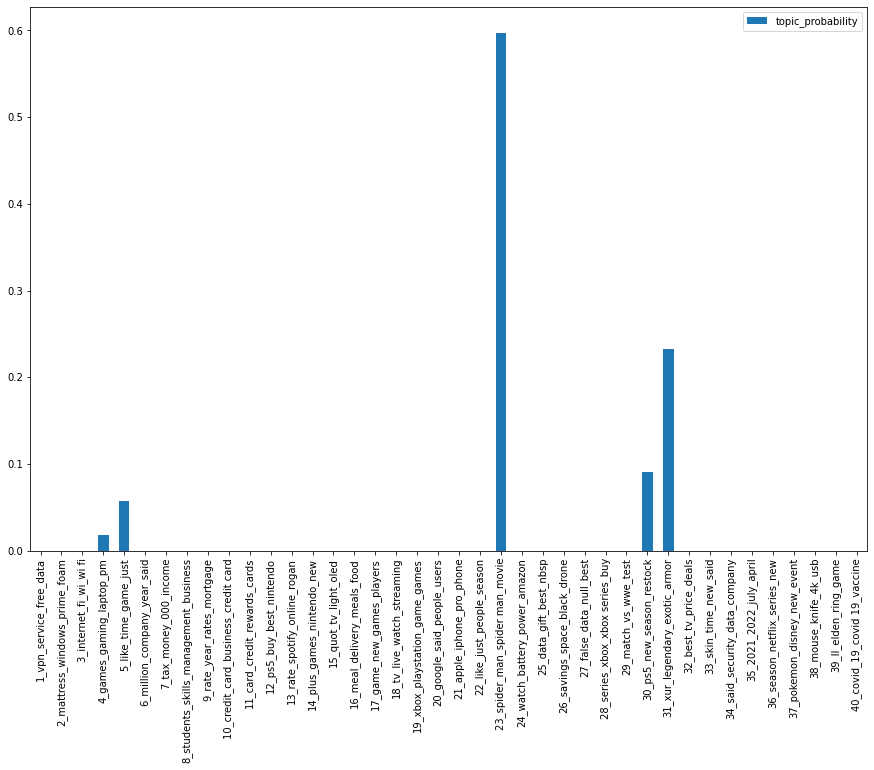

In [123]:
pd.DataFrame(index= topic_names, data= clusters[sample_idx], columns = ["topic_probability"]).plot.bar(figsize = (15,10), rot=90)
plt.show()